## Note: Jupyter Notebook Dataset Download
This step is not necessary but is included in the event where the examiner wishes to ensure the dataset is legitimate and not forcibly corrupted or altered by the candidate.

Should the examiner wish to download the fer2013 dataset themselves, please follow and execute the cells below.

In [ ]:
pip install opendatasets

In [7]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/msambare/fer2013")

On executing the above line, it will prompt for Kaggle username. Kaggle username can be fetched from the Account tab of the My Profile section.

On entering the username, it will prompt for Kaggle Key. Go to the account tab of the My Profile section and click on Create New API Token. This will download a kaggle.json file.

On opening the file, you will find the username and key in it. Copy the key and paste it into the prompted Jupyter Notebook cell to proceed with the download. However, should the examiner do this, the name of the folder will be different and has to be changed else it will affect the execution of the cells below. 

Reference: https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/

# Import libraries
Before executing the cell below, ensure that keras_tuner and tensorflow are installed. In the event they are not, creating a new cell and executing the following commands should enable it to run without any problems:
- pip install tensorflow
- pip install keras_tuner

In [1]:
from sklearn import preprocessing
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16, ResNet50V2, VGG19, ResNet101, ResNet152
from tensorflow.keras.callbacks import EarlyStopping

# Information about the dataset (train)

In [2]:
plot_emotions = []
for emotion in os.listdir("fer2013/train"):
    print(str(len(os.listdir("fer2013/train/" + emotion))) + " " + emotion + " images")
    number_of_images = len(os.listdir("fer2013/train/" + emotion))
    plot_emotions.append([str(emotion), number_of_images])

7215 happy images
4830 sad images
4097 fear images
3171 surprise images
4965 neutral images
3995 angry images
436 disgust images


## Plot
We can plot a bar graph for visual representation of the different emotion images.

Reference: https://stackoverflow.com/questions/34029865/how-to-plot-bar-chart-for-a-list-in-python

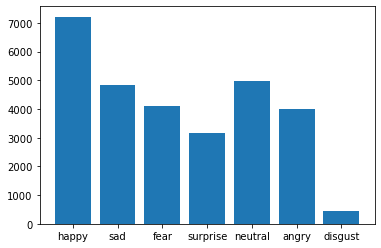

In [3]:
labels, ys = zip(*plot_emotions)
xs = np.arange(len(labels)) 
width = 0.8

plt.bar(xs, ys, width, align='center')
plt.xticks(xs, labels)

plt.show()

## Extracting file information

Extracts the filepath of the images and their associated labels and appending them to the imagefiles list and labels list.

Checks if the length of the imagefiles list corresponds to the length of the labels list, as each imagefile requires a label.

In [4]:
def prepare_files(directory):
    imagefiles = []
    labels = []

    for label in os.listdir(directory): # label refers to the emotion, eg. happy, sad
        for filename in os.listdir(directory + label): # access the files for each emotion; directory requires '/' at the end
            imagefile = os.path.join(directory, label, filename) # joining to create the filepath for the images
            imagefiles.append(imagefile) # save image paths and labels together
            labels.append(label)
            
    # ensure that each imagefile has a label
    if len(labels) == len(imagefiles):
        print("Successfully prepared", len(labels), "files")
        return imagefiles, labels
    else: 
        print("Something went wrong")
        return None

### Extracting file information for train data
We first create 2 separate lists to store the information.

In [5]:
train_directory = "fer2013/train/"
# Instantiate lists for image and label
train_image = []
train_label = []
train_image, train_label = prepare_files(train_directory)

Successfully prepared 28709 files


We can combine the 2 lists into one and convert it to a pandas DataFrame for neater representation.

In [6]:
train_list = []
for img, lbl in zip(train_image, train_label):
    train_list.append([img, lbl])

In [7]:
# Checking if we retain the information
print(len(train_list))

28709


In [8]:
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
train_df

,image,label
0,fer2013/train/happy/Training_50449107.jpg,happy
1,fer2013/train/happy/Training_70433018.jpg,happy
2,fer2013/train/happy/Training_85610005.jpg,happy
3,fer2013/train/happy/Training_4460748.jpg,happy
4,fer2013/train/happy/Training_6312930.jpg,happy
...,...,...
28704,fer2013/train/disgust/Training_94788538.jpg,disgust
28705,fer2013/train/disgust/Training_81049148.jpg,disgust
28706,fer2013/train/disgust/Training_28365203.jpg,disgust
28707,fer2013/train/disgust/Training_39197750.jpg,disgust


Then, we can save the DataFrame as a csv file for fast access.

In [50]:
train_df.to_csv('train.csv')

In [71]:
train_csv = pd.read_csv("train.csv",usecols=[1,2])
train_csv

,image,label
0,fer2013/train/happy/Training_50449107.jpg,happy
1,fer2013/train/happy/Training_70433018.jpg,happy
2,fer2013/train/happy/Training_85610005.jpg,happy
3,fer2013/train/happy/Training_4460748.jpg,happy
4,fer2013/train/happy/Training_6312930.jpg,happy
...,...,...
28704,fer2013/train/disgust/Training_94788538.jpg,disgust
28705,fer2013/train/disgust/Training_81049148.jpg,disgust
28706,fer2013/train/disgust/Training_28365203.jpg,disgust
28707,fer2013/train/disgust/Training_39197750.jpg,disgust


Then, we ensure that the content saved in the csv file is accurate.

In [73]:
train_csv.equals(train_df)

True

### Extracting file information for test data
We do the same process for test data.

In [9]:
directory = "fer2013/test/"
# Instantiate lists for image and label
test_image = []
test_label = []
test_image, test_label = prepare_files(directory)

Successfully prepared 7178 files


Then, we also combine the 2 lists and convert it to a pandas DataFrame.

In [10]:
test_list = []
for img, lbl in zip(test_image, test_label):
    test_list.append([img, lbl])
    
# Checking if we retain the information
print(len(test_list))

7178


In [11]:
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
test_df

,image,label
0,fer2013/test/happy/PrivateTest_45699463.jpg,happy
1,fer2013/test/happy/PrivateTest_61855708.jpg,happy
2,fer2013/test/happy/PublicTest_53681781.jpg,happy
3,fer2013/test/happy/PrivateTest_52109800.jpg,happy
4,fer2013/test/happy/PublicTest_41104919.jpg,happy
...,...,...
7173,fer2013/test/disgust/PrivateTest_79683471.jpg,disgust
7174,fer2013/test/disgust/PrivateTest_34013087.jpg,disgust
7175,fer2013/test/disgust/PublicTest_67559665.jpg,disgust
7176,fer2013/test/disgust/PrivateTest_89077668.jpg,disgust


In [69]:
test_df.to_csv('test.csv')

In [70]:
test_csv = pd.read_csv("test.csv",usecols=[1,2])
test_csv

,image,label
0,fer2013/test/happy/PrivateTest_45699463.jpg,happy
1,fer2013/test/happy/PrivateTest_61855708.jpg,happy
2,fer2013/test/happy/PublicTest_53681781.jpg,happy
3,fer2013/test/happy/PrivateTest_52109800.jpg,happy
4,fer2013/test/happy/PublicTest_41104919.jpg,happy
...,...,...
7173,fer2013/test/disgust/PrivateTest_79683471.jpg,disgust
7174,fer2013/test/disgust/PrivateTest_34013087.jpg,disgust
7175,fer2013/test/disgust/PublicTest_67559665.jpg,disgust
7176,fer2013/test/disgust/PrivateTest_89077668.jpg,disgust


In [74]:
test_csv.equals(test_df)

True

## Data preparation
Since our baseline is going to be convolutional neural network, a convnet takes as input tensors of shape (image_height, image_width, image_channels) (not including the batch dimension). In this case, we need to configure the convnet to process inputs of size (48, 48, 1), which is the format of the fer2013 images. So we first have to reshape them into the appropriate tensor shape. Then we pass the argument input_shape=(48, 48, 1) to the first layer afterwards.

In [12]:
def prepare_features(imagefiles):
    features = []
    for imagefile in imagefiles:
        # grayscale=True has deprecated so switched to color_mode="grayscale"
        # Reads the image
        imagedata = load_img(imagefile[0], color_mode="grayscale")
        # Convert image data to array
        imagedata = image.img_to_array(imagedata)
        # Scale image data
        imagedata /= 255.
        features.append(imagedata)
    # Wrap all data into a numpy array at the end
    features = np.array(features)
    print("Tensor shape:", features.shape)
    return features

Since we are incorporating transfer learning as well, the pretrained convolutional neural networks (convnets) require an input shape of (48, 48, 3) instead of having one channel. Thus, we can define another function similar to prepare_features and call it prepare_features_3 which outputs the tensor shape (48, 48, 3). Then, we will use the output tensor to the pretrained convnets.

In [38]:
def prepare_features_3(imagefiles):
    features = []
    for imagefile in imagefiles:
        # Reads the image
        imagedata = load_img(imagefile[0])
        # Convert image data to array
        imagedata = image.img_to_array(imagedata)
        # Scale image data
        imagedata /= 255.
        features.append(imagedata)
    # Wrap all data into a numpy array at the end
    features = np.array(features)
    print("Tensor shape:", features.shape)
    return features

### Feature extraction (train)

We use the functions on train_list and acquired the image data for both 1 channel and 3 channels. To improve time and space complexity, the two numpy arrays are saved as a .npy file so that they can be loaded instead of running the above process again. This improves efficiency and the same is done for the test dataset. 

In [12]:
x_train_data = prepare_features(train_list)

Tensor shape: (28709, 48, 48, 1)


In [44]:
x_train_data_3 = prepare_features_3(train_list)

Tensor shape: (28709, 48, 48, 3)


In [13]:
# Save the numpy array
np.save('x_train_data', x_train_data)
np.save('x_train_data_3', x_train_data_3)

In [14]:
# Load the numpy array
x_train = np.load('x_train_data.npy')

In [15]:
# Ensuring data is consistent
if x_train_data.all() == x_train.all():
    print("x_train data consistent")

x_train data consistent


### Feature extraction (test)

In [17]:
x_test_data = prepare_features(test_list)

Tensor shape: (7178, 48, 48, 1)


In [47]:
x_test_data_3 = prepare_features_3(test_list)

Tensor shape: (7178, 48, 48, 3)


In [18]:
# Save the numpy array
np.save('x_test_data', x_test_data)
np.save('x_test_data_3', x_test_data_3)

In [19]:
# Load the numpy array
x_test = np.load('x_test_data.npy')

In [20]:
if x_test_data.all() == x_test.all():
    print("x_test data consistent")

x_test data consistent


## Prepare labels data
Now, we prepare the data for the labels. Since the labels are in strings, we can use LabelEncoder to transform them into a simpler representation of numbers. Then, we can one hot encode them using the to_categorical method. 

In [15]:
# Instantiate LabelEncoder
le = preprocessing.LabelEncoder()
# Pass in our train_label list which contains the labels for the images to generate a list of unique emotions
le.fit(train_label)
list(le.classes_)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

### Prepare labels data (train)

From the above output, we can see that we generated our 7 different emotions. Now, we proceed to one hot encode our train_label list. 

We first use the .transform method to change the emotions represented as strings in our list to their respective index in the LabelEncoder class. Then, we can use the to_categorical method to perform one-hot encoding. The numpy array will go through the same process as the x datasets, saved as a .npy file and efficiently loaded instead of running the whole process again. The same is done for preparing the test labels data.

In [27]:
y_train_data = le.transform(train_label)
print(y_train_data)

[3 3 3 ... 1 1 1]


In [28]:
y_train_data = to_categorical(y_train_data)
y_train_data[0]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [30]:
np.save('y_train_data', y_train_data)

In [31]:
y_train = np.load('y_train_data.npy')

In [32]:
if y_train_data.all() == y_train.all():
    print("y_train data consistent")

y_train data consistent


### Prepare labels data (test)

In [34]:
y_test_data = le.transform(test_label)
print(y_test_data)

[3 3 3 ... 1 1 1]


In [35]:
y_test_data = to_categorical(y_test_data)

In [36]:
np.save('y_test_data', y_test_data)

In [37]:
# Load the numpy array
y_test = np.load('y_test_data.npy')

# Ensure both arrays match to retain the data
if y_test_data.all() == y_test.all():
    print("y_test data consistent")

y_test data consistent


## Hold-out validation

Hold-out validation is the process of splitting off part of the training set and using it for validation. The train_test_split function will be called to implement this. Validation dataset will consist of 20% of the training data, while partial training 80%. The model will be trained using the partial training data and tested on the validation data. random_state ensures that the splitting of data will not be significantly changed if the cell were to be executed on the same training data and thus ensures high reproducibility of results.

### Splitting of train data

In [20]:
partial_X_train, X_val, partial_y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [21]:
print(partial_X_train.shape)
print(X_val.shape)
print(partial_y_train.shape)
print(y_val.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)
(22967, 7)
(5742, 7)


Since Model A, which is a fully connected feedforward neural network, it requires a 1D tensor instead. Thus, reshape is called on the partial and validation training set, as well as the test dataset.

In [22]:
partial_X_train_fc = partial_X_train.reshape((22967, 48 * 48))
X_val_fc = X_val.reshape((5742, 48 * 48))

x_test_fc = x_test.reshape((7178, 48 * 48))

## Model A
Model A is a fully connected feedforward neural network with 3 Dense layers. The first layer neurons have to be higher than the input data, and thus will be 48x48 neurons. For subsequent layers, it should be higher. Hence, the second layer will be 2x48x48 neurons. L2 regularisation will also be implemented. The last layer will adopt the softmax activation and categorical_crossentropy as its loss function since the problem type is a multi-class, single-label classification. Since the dataset is small, a smaller batch_size is more suitable. The batch_size will be 64 and epochs 10 for a start. A seed will be set for high reproducibility of results.

In [23]:
# Build model
fc_model = models.Sequential()
fc_model.add(layers.Dense(48*48, activation='relu', input_shape=(48*48,), 
                          kernel_regularizer=tf.keras.regularizers.L2(0.00001)))
fc_model.add(layers.Dense(48*48*2, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.L2(0.00001)))
# output layer
fc_model.add(layers.Dense(7, activation='softmax'))

tf.random.set_seed(42)
fc_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

2022-06-27 16:04:12.774306: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
fc_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2304)              5310720   
                                                                 
 dense_1 (Dense)             (None, 4608)              10621440  
                                                                 
 dense_2 (Dense)             (None, 7)                 32263     
                                                                 
Total params: 15,964,423
Trainable params: 15,964,423
Non-trainable params: 0
_________________________________________________________________


In [25]:
# train the model
history = fc_model.fit(partial_X_train_fc, 
                       partial_y_train, 
                       epochs=10, 
                       batch_size=64, 
                       validation_data=(X_val_fc, y_val))

Epoch 1/10
359/359 [==============================] - 26s 72ms/step - loss: 1.9178 - accuracy: 0.2681 - val_loss: 1.7444 - val_accuracy: 0.3027
Epoch 2/10
359/359 [==============================] - 26s 73ms/step - loss: 1.7156 - accuracy: 0.3283 - val_loss: 1.6678 - val_accuracy: 0.3560
Epoch 3/10
359/359 [==============================] - 26s 72ms/step - loss: 1.6915 - accuracy: 0.3368 - val_loss: 1.6760 - val_accuracy: 0.3405
Epoch 4/10
359/359 [==============================] - 27s 75ms/step - loss: 1.6809 - accuracy: 0.3461 - val_loss: 1.6750 - val_accuracy: 0.3382
Epoch 5/10
359/359 [==============================] - 27s 77ms/step - loss: 1.6623 - accuracy: 0.3546 - val_loss: 1.6769 - val_accuracy: 0.3359
Epoch 6/10
359/359 [==============================] - 28s 78ms/step - loss: 1.6509 - accuracy: 0.3615 - val_loss: 1.6692 - val_accuracy: 0.3448
Epoch 7/10
359/359 [==============================] - 29s 81ms/step - loss: 1.6452 - accuracy: 0.3621 - val_loss: 1.6518 - val_accuracy:

In [26]:
# Test model on test dataset
test_loss, test_acc = fc_model.evaluate(x_test_fc, y_test)

225/225 [==============================] - 3s 12ms/step - loss: 1.6486 - accuracy: 0.3534


From the above output, Model A achieved 36% training accuracy and 35% testing accuracy. This is not too bad as the training and test accuracies are similar. We proceed with defining Model B to compare.

## Model B
Model B is a convolutional neural network (CNN) with 3 convolutional layers followed by MaxPooling for each layer and 3 fully connected layers. The input shape is (48, 48, 1). The neurons for the convolutional layers are first set to 64, kernel size to (3,3) and L2 regularisation to 0.00001 as well, to ensure a fair comparison with Model A. The pool size for MaxPooling was set to (2,2) to reduce the features by half. Then, a Flatten layer was added to “convert all the 2-Dimensional (2D) arrays into a single vector ... used as input to the fully connected layers to classify the image” (Biswal, 2022). The fully connected layers were implemented with 128 neurons. The model undergoes the same procedure for training. 

In [27]:
model = models.Sequential()

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(48,48,1), 
                 kernel_regularizer=tf.keras.regularizers.L2(0.00001)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', 
                 kernel_regularizer=tf.keras.regularizers.L2(0.00001)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', 
                 kernel_regularizer=tf.keras.regularizers.L2(0.00001)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# fully connected layers
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.00001)))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.00001)))
# output layer
model.add(Dense(7, activation='softmax'))

tf.random.set_seed(42)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)        

In [29]:
# train the model
history = model.fit(partial_X_train, 
                    partial_y_train, 
                    batch_size=64, 
                    epochs=10, 
                    validation_data=(X_val, y_val))

Epoch 1/10
359/359 [==============================] - 48s 132ms/step - loss: 1.7351 - accuracy: 0.3021 - val_loss: 1.5533 - val_accuracy: 0.4028
Epoch 2/10
359/359 [==============================] - 51s 141ms/step - loss: 1.4850 - accuracy: 0.4266 - val_loss: 1.4167 - val_accuracy: 0.4467
Epoch 3/10
359/359 [==============================] - 49s 136ms/step - loss: 1.3538 - accuracy: 0.4813 - val_loss: 1.3057 - val_accuracy: 0.4993
Epoch 4/10
359/359 [==============================] - 49s 138ms/step - loss: 1.2637 - accuracy: 0.5211 - val_loss: 1.2771 - val_accuracy: 0.5132
Epoch 5/10
359/359 [==============================] - 51s 141ms/step - loss: 1.1958 - accuracy: 0.5487 - val_loss: 1.2301 - val_accuracy: 0.5345
Epoch 6/10
359/359 [==============================] - 53s 148ms/step - loss: 1.1361 - accuracy: 0.5716 - val_loss: 1.2280 - val_accuracy: 0.5369
Epoch 7/10
359/359 [==============================] - 52s 145ms/step - loss: 1.0856 - accuracy: 0.5927 - val_loss: 1.2180 - val_ac

In [30]:
baseline_history = history.history
baseline_history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Model B accuracy graph 

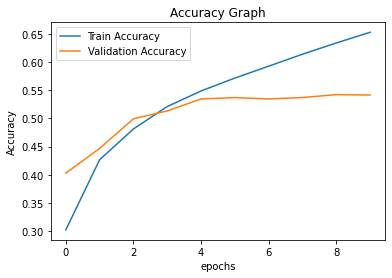

In [31]:
plt.plot(baseline_history['accuracy'], label="Train Accuracy") # blue 
plt.plot(baseline_history['val_accuracy'], label="Validation Accuracy") # orange
plt.legend()
plt.title('Accuracy Graph')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()

In [32]:
test_loss, test_acc = model.evaluate(x_test, y_test)

225/225 [==============================] - 4s 18ms/step - loss: 1.2591 - accuracy: 0.5489


In [43]:
# Save the model
model.save('cnn_3layers.h5')

# Load the model to evaluate test data
model = load_model('cnn_3layers.h5')

# Prints model summary to ensure it is consistent
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [32]:
test_loss, test_acc = model.evaluate(x_test, y_test)

225/225 [==============================] - 4s 18ms/step - loss: 1.2591 - accuracy: 0.5489


Model B achieved 65% training accuracy and 54% testing accuracy. The model performed better than Model A, as predicted. Looking at the accuracy graph, there may be some slight overfitting, but at this point in time, it is not a problem. Model C is implemented to further test the first hypothesis of whether deeper layers increase accuracy and determine the final baseline model.

## Model C
Model C has the same architecture as B, but consists of 2 convolutional layers. The model undergoes the same procedure.

In [45]:
model = models.Sequential()

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(48,48,1), 
                 kernel_regularizer=tf.keras.regularizers.L2(0.00001)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', 
                 kernel_regularizer=tf.keras.regularizers.L2(0.00001)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# fully connected layers
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.00001)))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.00001)))
# output layer
model.add(Dense(7, activation='softmax'))

tf.random.set_seed(42)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [47]:
# train the model
history = model.fit(partial_X_train, 
                    partial_y_train, 
                    batch_size=64, 
                    epochs=10, 
                    validation_data=(X_val, y_val))

Epoch 1/10
359/359 [==============================] - 79s 216ms/step - loss: 1.6509 - accuracy: 0.3487 - val_loss: 1.4902 - val_accuracy: 0.4333
Epoch 2/10
359/359 [==============================] - 77s 215ms/step - loss: 1.4160 - accuracy: 0.4539 - val_loss: 1.3949 - val_accuracy: 0.4648
Epoch 3/10
359/359 [==============================] - 77s 214ms/step - loss: 1.3079 - accuracy: 0.5001 - val_loss: 1.3152 - val_accuracy: 0.5002
Epoch 4/10
359/359 [==============================] - 76s 213ms/step - loss: 1.2178 - accuracy: 0.5389 - val_loss: 1.3225 - val_accuracy: 0.4979
Epoch 5/10
359/359 [==============================] - 74s 206ms/step - loss: 1.1346 - accuracy: 0.5742 - val_loss: 1.2867 - val_accuracy: 0.5091
Epoch 6/10
359/359 [==============================] - 74s 205ms/step - loss: 1.0494 - accuracy: 0.6085 - val_loss: 1.2778 - val_accuracy: 0.5212
Epoch 7/10
359/359 [==============================] - 74s 206ms/step - loss: 0.9612 - accuracy: 0.6435 - val_loss: 1.3227 - val_ac

In [13]:
# Define plotting of the accuracy graph for efficiency
def plot_graph(history):
    plt.plot(history['accuracy'], label="Train Accuracy") # blue 
    plt.plot(history['val_accuracy'], label="Validation Accuracy") # orange
    plt.legend()
    plt.title('Accuracy Graph')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.show()

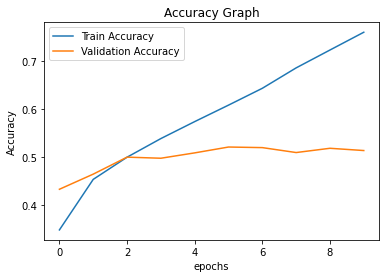

In [48]:
cnn_2layers_history = history.history
plot_graph(cnn_2layers_history)

In [49]:
# Save the model
model.save('cnn_2layers.h5')

# Load the model to evaluate test data
model = load_model('cnn_2layers.h5')

# Prints model summary to ensure it is consistent
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [50]:
test_loss, test_acc = model.evaluate(x_test, y_test)

225/225 [==============================] - 8s 30ms/step - loss: 1.5152 - accuracy: 0.5222


Comparing the results of the Models B and C, even though the training accuracy for the Model C with 2 convolutional layers is higher, Model B with 3 convolutional layers has a higher test accuracy and it overfits lesser, as can be seen comparing the two graphs. Thus, we can conclude that the optimal number of convolutional layers is 3 between the 2 models. Model B will serve as a baseline model. We then proceed with tuning the units and filters of the layers using the library keras_tuner Hyperband to tune the hyperparameters for optimization. Continuation of the process flow can be found in Notebook 2.

# Live Demonstration
The codes for live demonstration is adapted from .

Original Output: happy
Predicted Output: happy


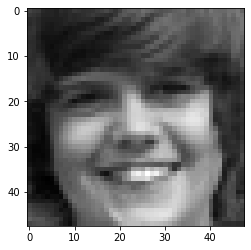

In [45]:
img = random.randint(0, len(test_list))
print("Original Label:", test_list[img][1])
pred = model.predict(x_test[img].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Label:", prediction_label)
plt.imshow(x_test[img].reshape(48, 48), cmap='gray');

# Visualizing what the model convnets learn 

In [36]:
img_path = "fer2013/train/sad/Training_25533531.jpg"
# img = image.load_img(img_path, target_size=(48,48)) 
img = image.load_img(img_path, target_size=(48,48), color_mode="grayscale") 
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 48, 48, 1)


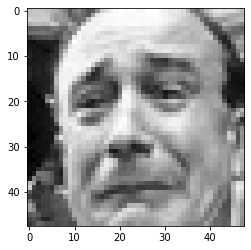

In [37]:
plt.imshow(img_tensor[0], cmap='gray')
plt.show()

In [38]:
# Extracts the outputs of the top 5 layers 
layer_outputs = [layer.output for layer in model.layers[:5]] 
# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [39]:
# Returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)

In [40]:
# activation of the first convolution layer for the man image input
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 46, 46, 64)


## Visualizing the fourth channel

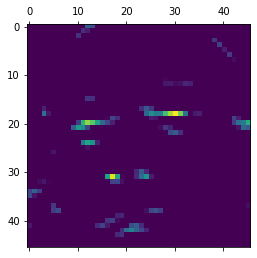

In [41]:
# plotting the fourth channel of the activation of the first layer of the original model 
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')

This channel appears to encode a horizontal line detector. 

## Compare all layers 
Here, we can see the features learnt layer by layer, the convolutional and maxpool layers. 

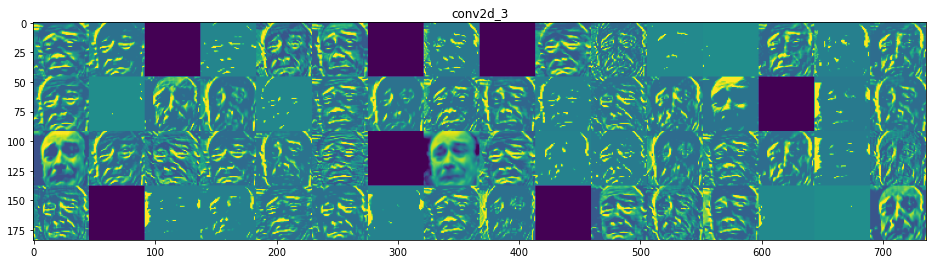

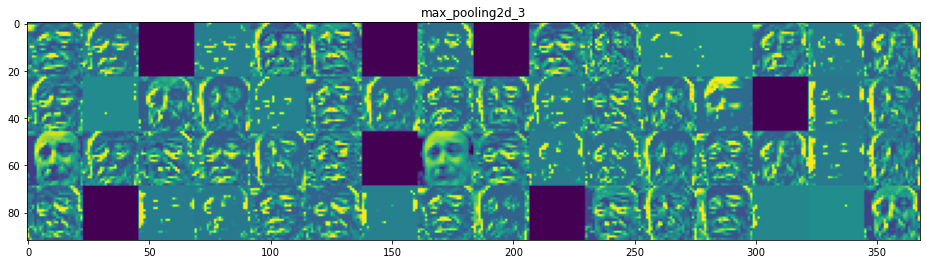

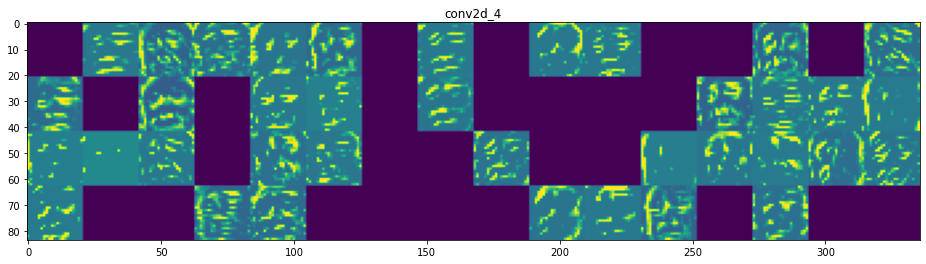

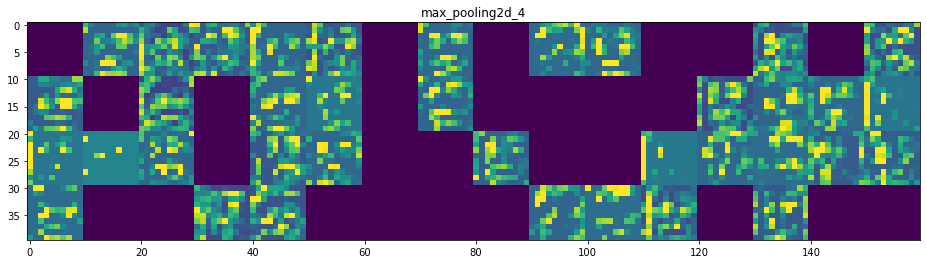

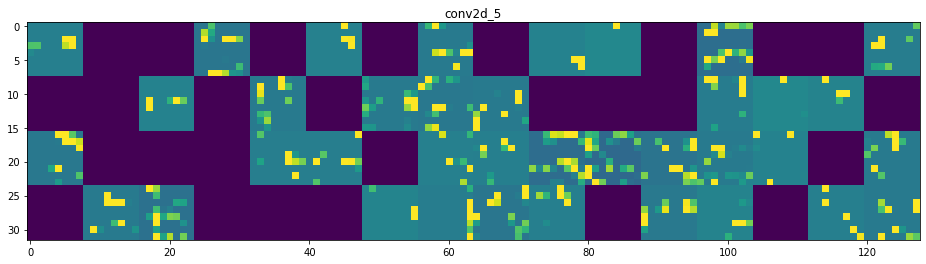

In [73]:
# Names of the layers, so you can have them as part of your plot
layer_names = []
for layer in model.layers[:10]:
    layer_names.append(layer.name)

images_per_row = 16
# Displays the feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # Number of features in the feature map
    n_features = layer_activation.shape[-1]
    
    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]
    
    # Tiles the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    # Tiles each filter into a big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # Post-processes the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            # Displays the grid
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

We can see how the features were reduced by half using MaxPool and in the last convolutional layer, the more prominent features were presented.

## Comparing the convolutional layers 
Here, we simply show the comparison between the convolutional layers, without the MaxPool layers.

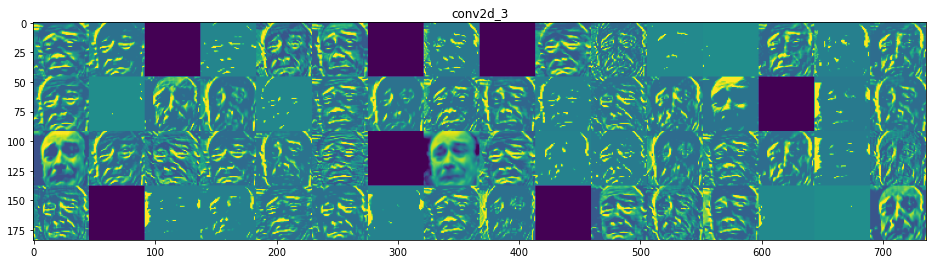

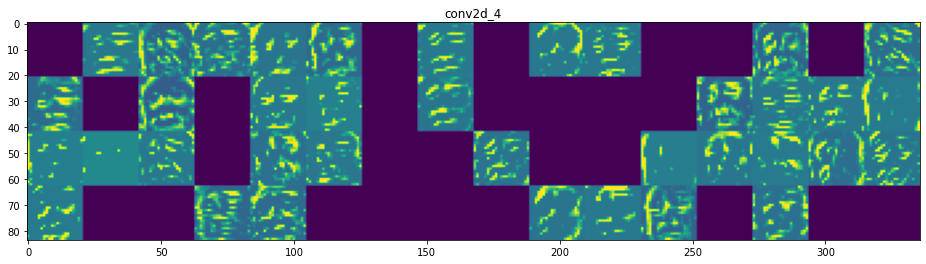

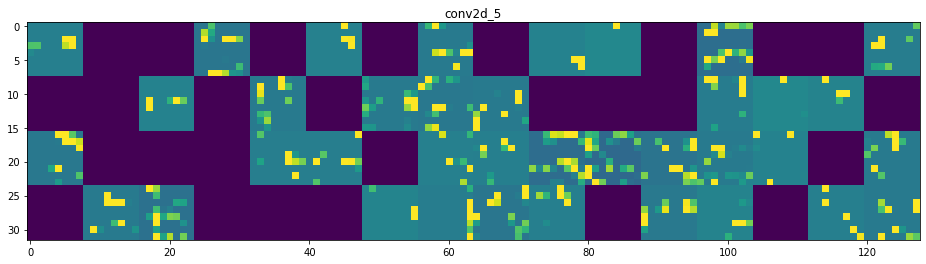

In [74]:
# Names of the layers, so you can have them as part of your plot
layer_names = []
for layer in model.layers[:5]:
    layer_names.append(layer.name)
images_per_row = 16
# Displays the feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    if 'conv' in layer_name:
        # Number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # Tiles the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # Tiles each filter into a big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                # Post-processes the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                # Displays the grid
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

# References

1. (Biswal, 2022)

Biswal, A., 2022. Convolutional Neural Network Tutorial. [online] simplilearn. Available at: <https://www.simplilearn.com/tutorials/deep-learning-tutorial/convolutional-neural-network>

2. 